# Imports and Initialization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [2]:
import som_class

In [3]:
distance_threshold = 10
alpha = 0.012
startradius = 100
endradius = 1
iterations = 10
epsilon = 4

In [4]:
som = som_class.SOM(distance_threshold, alpha, startradius, endradius, iterations, epsilon)

# First gather positions in original images by using U-Net

## Load U-Net

In [5]:
import tensorflow as tf
import os
import skimage.io

unet = tf.keras.models.load_model("unet_mixedfloat16.h5", compile=False)

2024-05-06 12:31:59.660303: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 12:32:00.708218: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6


2024-05-06 12:32:02.051997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 12:32:02.260250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 12:32:02.260315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 12:32:02.260761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 12:32:02.288373: I tensorflow/compile

## Set folders and scan for images

In [6]:
image_folder = 'example_images/'
image_files = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(".bmp")]
image_files.sort()
particle_folder = 'positions/'

## Get particle positions of every image by U-Net

In [7]:
for filename in image_files:
    image_tensor = tf.keras.utils.load_img(filename, color_mode='grayscale', target_size=None)
    image_tensor = np.expand_dims(image_tensor, axis=0)
    image_tensor = np.expand_dims(image_tensor, axis=-1) / 255
    unet_result = unet(image_tensor)
    particle_mask = unet_result[0, :, :, 0]>0.99
    particles = np.array(skimage.measure.regionprops(skimage.measure.label(particle_mask)))
    if len(particles) > 0:
        particles = np.array([c["Centroid"] for c in particles])
        particles[:, [0, 1]] = particles[:,[1, 0]]  # correcting, so particles[:,0] is x and particles[:,1] is y
        np.save(particle_folder + filename.split('/')[1].split('.')[0] + '.npy', particles)

2024-05-06 12:32:12.517264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


## Plot example image

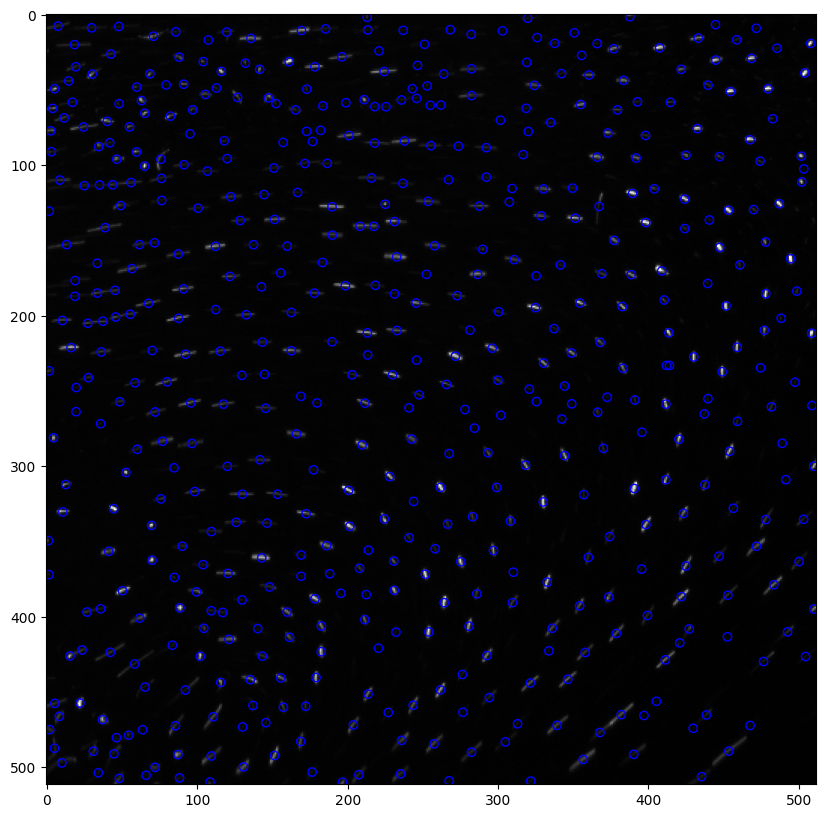

In [8]:
img = np.array(Image.open(image_files[0]))/255
particles_to_show = np.load(particle_folder + image_files[0].split('/')[1].split('.')[0] + '.npy')
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap="gray")
plt.scatter(particles_to_show[:, 0], particles_to_show[:, 1], facecolors='None',edgecolors='blue')
plt.show()

# Matching two images with SOM

## First read in particles of 2 images

In [9]:
filename1 = particle_folder + image_files[0].split('/')[1].split('.')[0] + '.npy'
filename2 = particle_folder + image_files[1].split('/')[1].split('.')[0] + '.npy'
coords1, coords2 = som.read_in_coordinates(filename1, filename2) 

## Now match particles: Third row of coords2 will be changed according to matching

In [10]:
coords1, coords2 = som.match_particles(coords1, coords2)

## Plot particles with connecting arrows for visualization

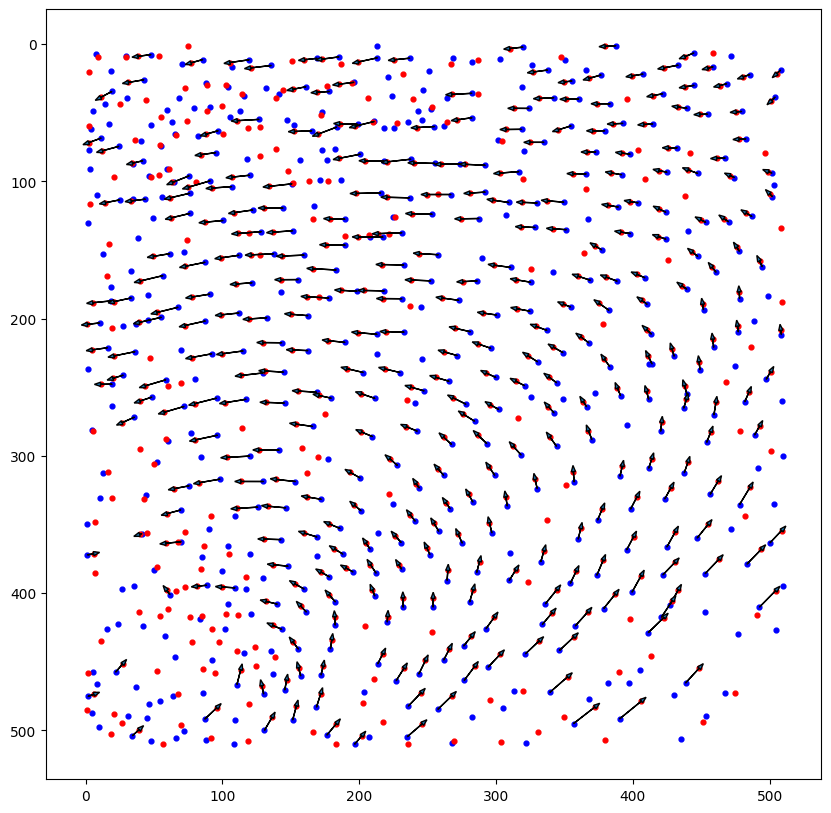

343 particles of 528 matched.


In [11]:
plt.figure(figsize=(10, 10))
plt.scatter(coords1[:,0],coords1[:,1],c='blue',s=12)
plt.scatter(coords2[:,0],coords2[:,1],c='red',s=12)
i = 0
for particle in coords2:
    if particle[2] in coords1[:,2]:
        i+=1
        coords1_id = np.where(coords1[:,2]==particle[2])[0][0]
        coords2_id = np.where(coords2[:,2]==particle[2])[0][0]
        plt.arrow(coords1[coords1_id][0],coords1[coords1_id][1],coords2[coords2_id][0]-coords1[coords1_id][0],coords2[coords2_id][1]-coords1[coords1_id][1], head_width=3)
plt.gca().invert_yaxis()
plt.show()
print(str(i)+' particles of '+str(len(coords1))+' matched.')

# When images are 2048x2048 you can do this:

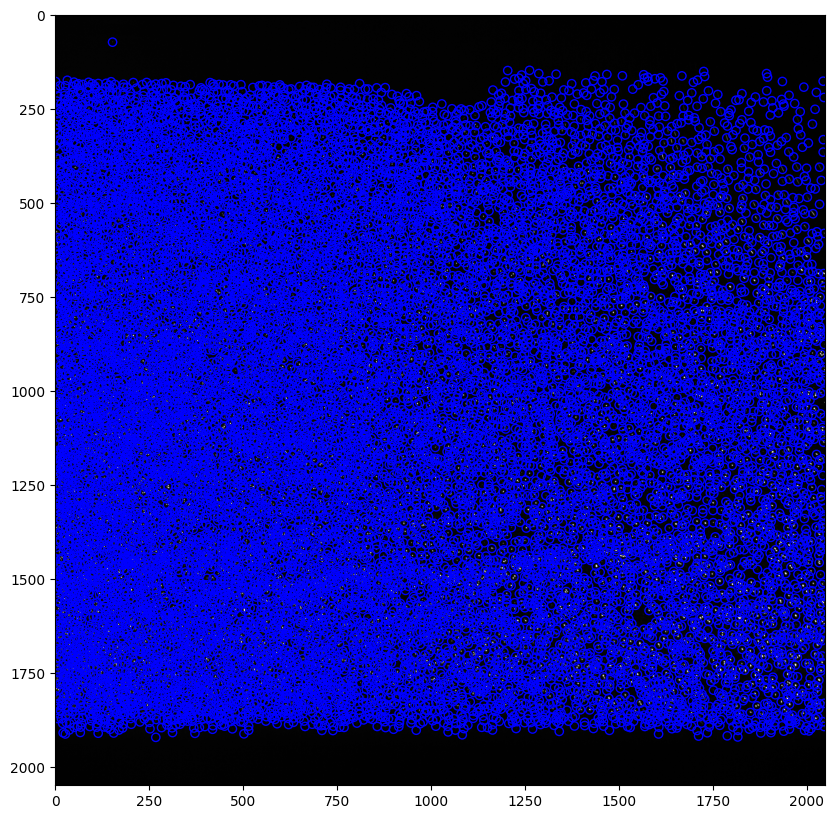

In [12]:
image_folder = '2048_example_images/'
#image_folder = '2048_example_images_2/'
image_files = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(".bmp")]
image_files.sort()
particle_folder = '2048_positions/'
#particle_folder = '2048_positions_2/'
for filename in image_files:
    image_tensor = tf.keras.utils.load_img(filename, color_mode='grayscale', target_size=None)
    image_tensor = np.expand_dims(image_tensor, axis=0)
    image_tensor = np.expand_dims(image_tensor, axis=-1) / 255
    unet_result = unet(image_tensor)
    particle_mask = unet_result[0, :, :, 0]>0.99
    particles = np.array(skimage.measure.regionprops(skimage.measure.label(particle_mask)))
    if len(particles) > 0:
        particles = np.array([c["Centroid"] for c in particles])
        particles[:, [0, 1]] = particles[:,[1, 0]]  # correcting, so particles[:,0] is x and particles[:,1] is y
        np.save(particle_folder + filename.split('/')[1].split('.')[0] + '.npy', particles)
img = np.array(Image.open(image_files[0]))/255
particles_to_show = np.load(particle_folder + image_files[0].split('/')[1].split('.')[0] + '.npy')
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap="gray")
plt.scatter(particles_to_show[:, 0], particles_to_show[:, 1], facecolors='None',edgecolors='blue')
plt.show()

In [13]:
filename1 = particle_folder + image_files[0].split('/')[1].split('.')[0] + '.npy'
filename2 = particle_folder + image_files[1].split('/')[1].split('.')[0] + '.npy'
coords1, coords2 = som.read_in_coordinates(filename1, filename2) 
coords1, coords2 = som.match_2048_images(coords1, coords2)

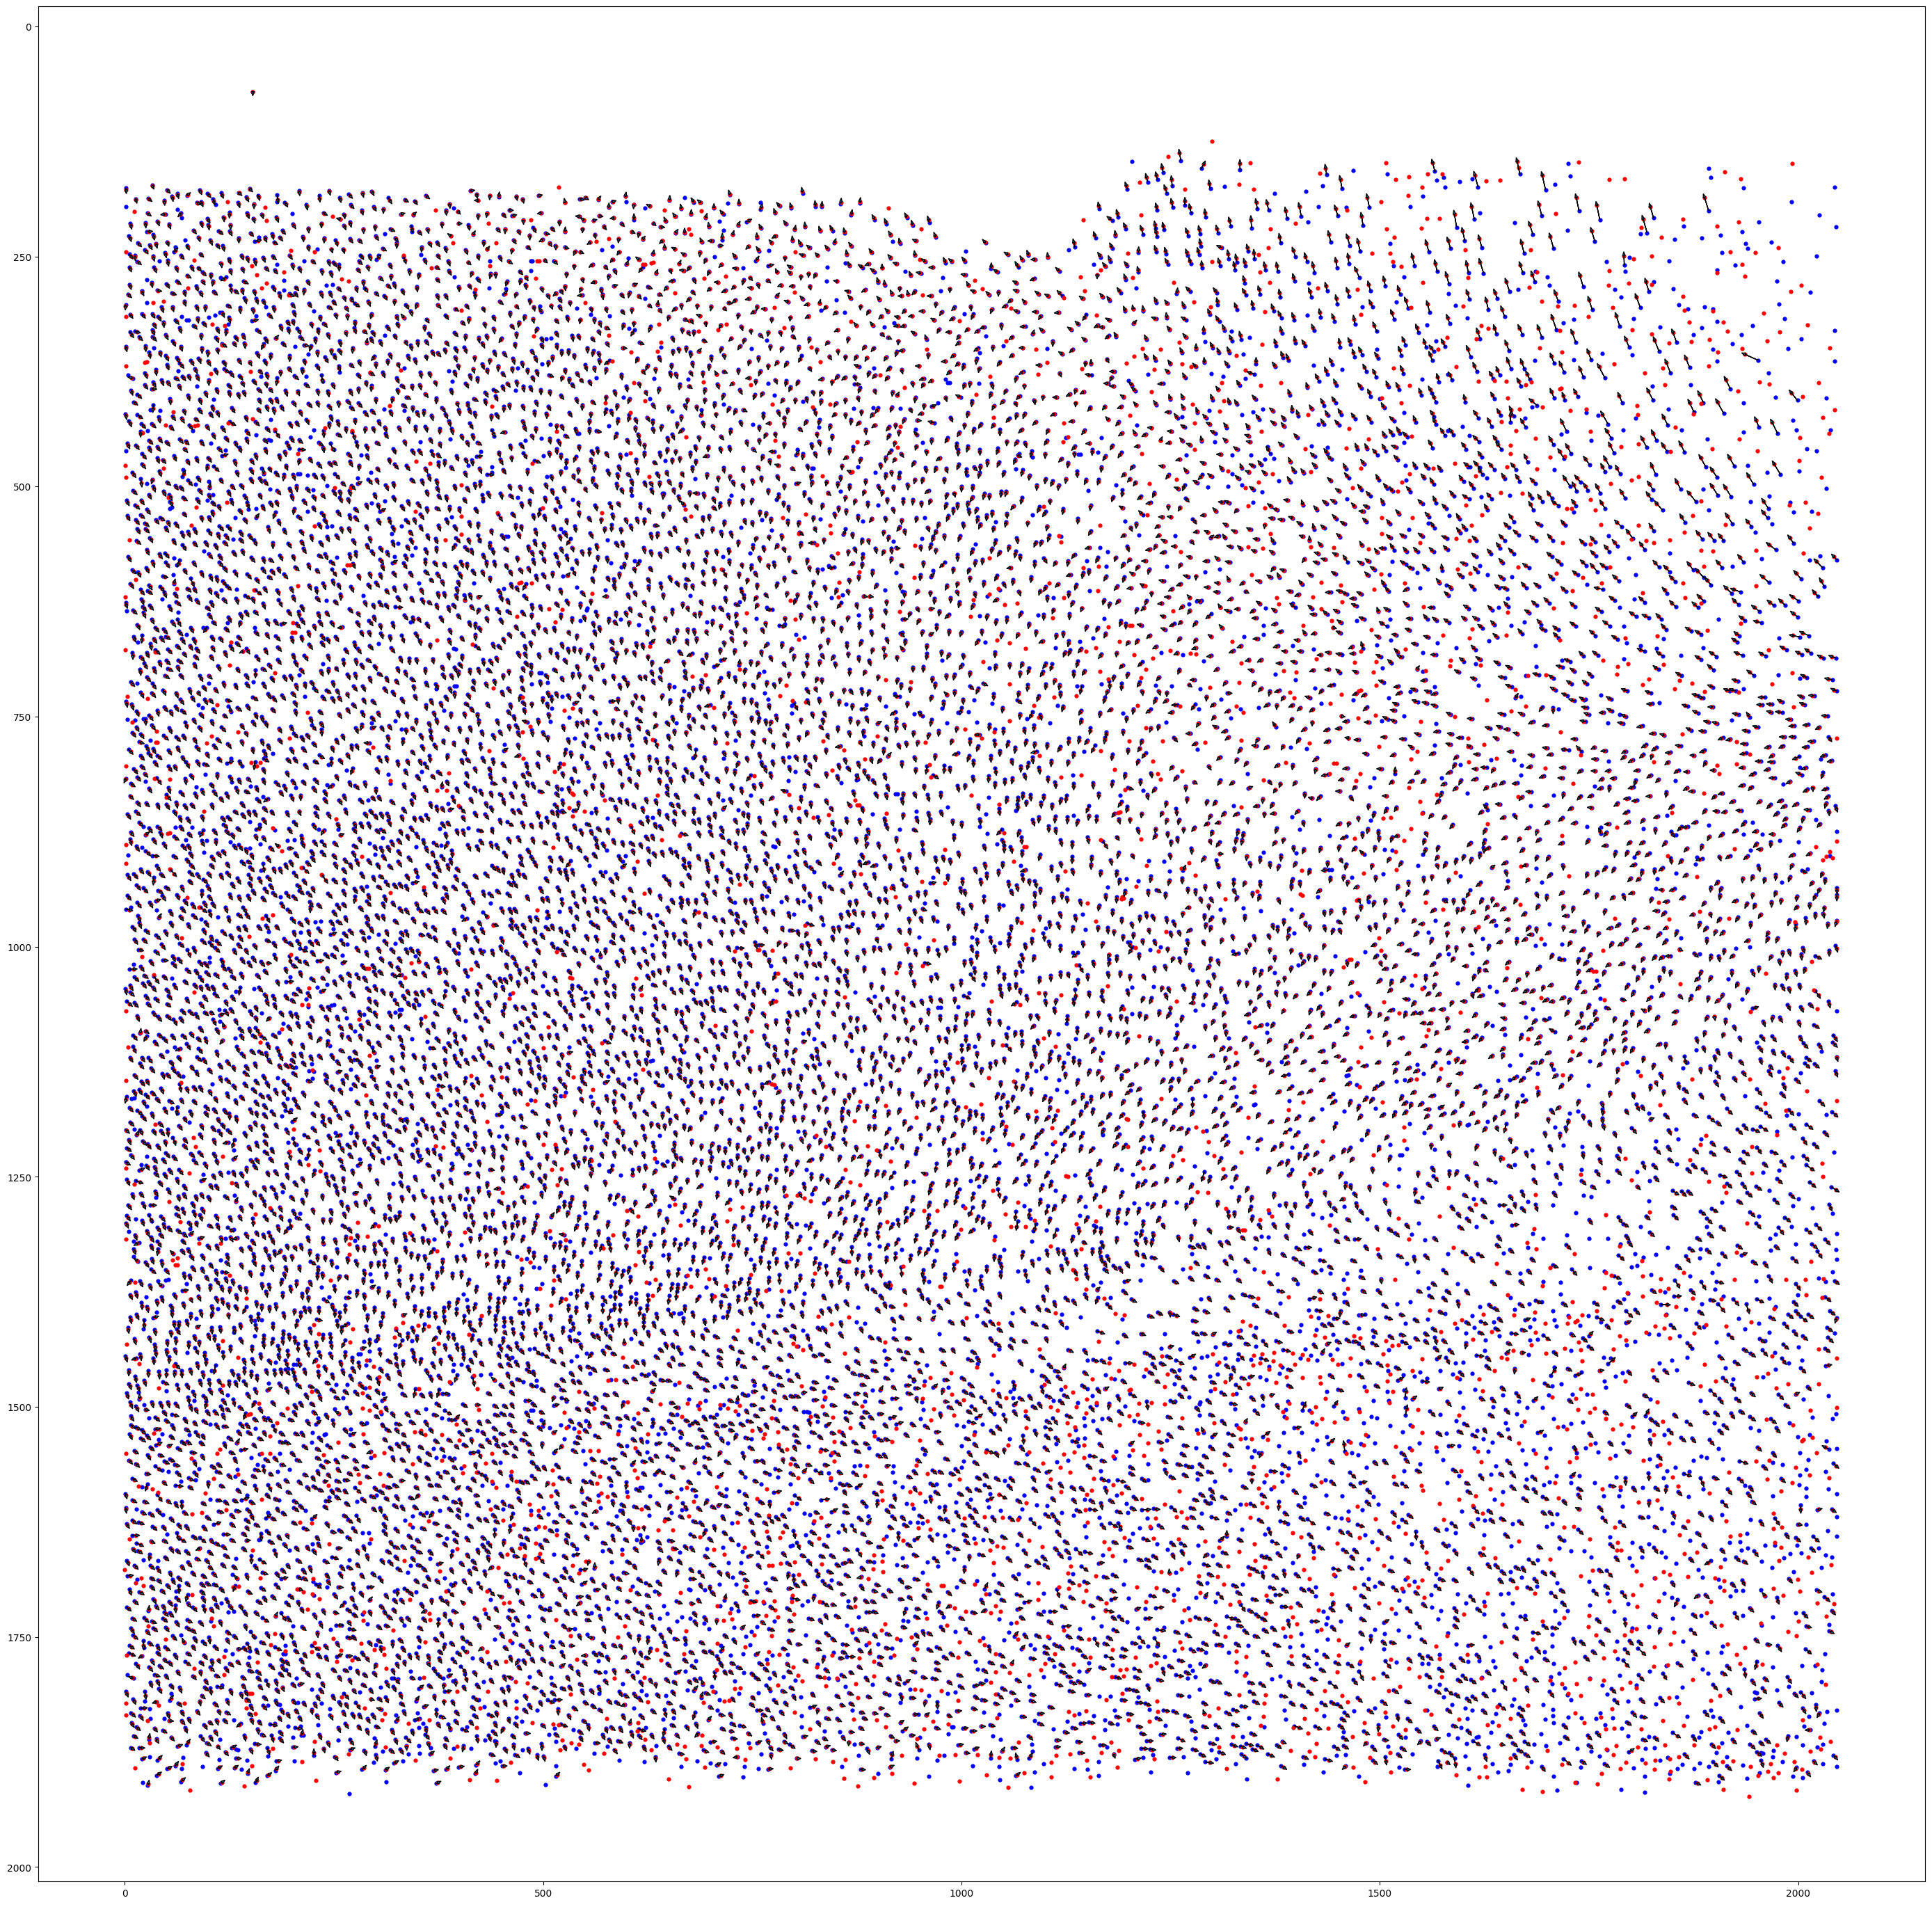

12316 particles of 15207 matched.


In [14]:
plt.figure(figsize=(35, 35))
plt.scatter(coords1[:,0],coords1[:,1],c='blue',s=12)
plt.scatter(coords2[:,0],coords2[:,1],c='red',s=12)
i = 0
for particle in coords2:
    if particle[2] in coords1[:,2]:
        i+=1
        coords1_id = np.where(coords1[:,2]==particle[2])[0][0]
        coords2_id = np.where(coords2[:,2]==particle[2])[0][0]
        plt.arrow(coords1[coords1_id][0],coords1[coords1_id][1],coords2[coords2_id][0]-coords1[coords1_id][0],coords2[coords2_id][1]-coords1[coords1_id][1], head_width=3)
plt.gca().invert_yaxis()
plt.show()
print(str(i)+' particles of '+str(len(coords1))+' matched.')

# Tracing particles over multipe images:

finished number 1
finished number 2
finished number 3
finished number 4
finished number 5
finished number 6
finished number 7
finished number 8
finished number 9
finished number 10
finished number 11
finished number 12
finished number 13
finished number 14
finished number 15
finished number 16
finished number 17
finished number 18
finished number 19
finished number 20
finished number 21
finished number 22
finished number 23
finished number 24
finished number 25
finished number 26
finished number 27
finished number 28
finished number 29
finished number 30
finished number 31
finished number 32
finished number 33
finished number 34
finished number 35
finished number 36
finished number 37
finished number 38
finished number 39
finished number 40
finished number 41
finished number 42
finished number 43
finished number 44
finished number 45
finished number 46
finished number 47
finished number 48
finished number 49
finished number 50
now tracing


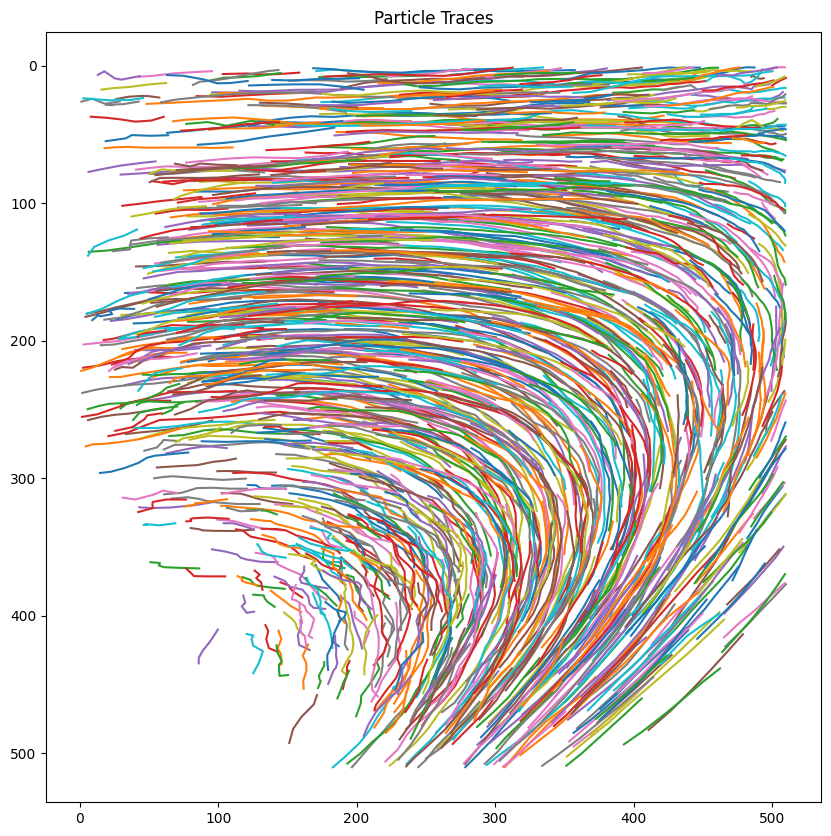

In [15]:
allmatches = np.array((),dtype=object)
original_coords = np.array((),dtype=object)
images_to_match = 50
particle_folder = 'positions/'
position_files = [os.path.join(particle_folder, img) for img in os.listdir(particle_folder) if img.endswith(".npy")]
position_files.sort()
min_length = 5
for i in range(min(images_to_match,len(position_files)-1)):
    filename1 = position_files[i]
    filename2 = position_files[i+1]
    coords1, coords2 = som.read_in_coordinates(filename1, filename2)
    coords1, coords2 = som.match_particles(coords1, coords2)
    if i==0:
        match = np.array((coords1,coords2),dtype=object)
    else:
        match = np.array([coords2,None],dtype=object)
        match = np.delete(match,1)
    orig_coords = np.array([coords1,None],dtype=object)
    orig_coords = np.delete(orig_coords,1)
    allmatches = np.append(allmatches,match)
    original_coords = np.append(original_coords,orig_coords)
    print(f"finished number {i+1}")
print("now tracing")
allmatches = som.tracing(allmatches,original_coords)
starting_image = int(position_files[0].split('/')[1].split('.')[0])
dataframe = som.convert_to_dataframe(allmatches,starting_image)
filtered_particles = som.dataframe_min_length_filter(dataframe,min_length)
som.plot_traces(filtered_particles)

# Multiprocessing Example (for 2048 images, as it is slower):

finished image number 1
finished image number 2
finished image number 3
finished image number 4
finished image number 5
finished image number 6
finished image number 7
finished image number 8
finished image number 9
finished image number 10
finished image number 11
finished image number 12
finished image number 13
finished image number 14
finished image number 15
finished image number 16
finished image number 17
finished image number 18
finished image number 19
finished image number 20
finished image number 21
finished image number 22
finished image number 23
finished image number 24
finished image number 25
finished image number 26
finished image number 27
finished image number 28
finished image number 29
finished image number 30
finished image number 31
finished image number 32
finished image number 33
finished image number 34
finished image number 35
finished image number 36
finished image number 37
finished image number 38
finished image number 39
finished image number 40
finished 

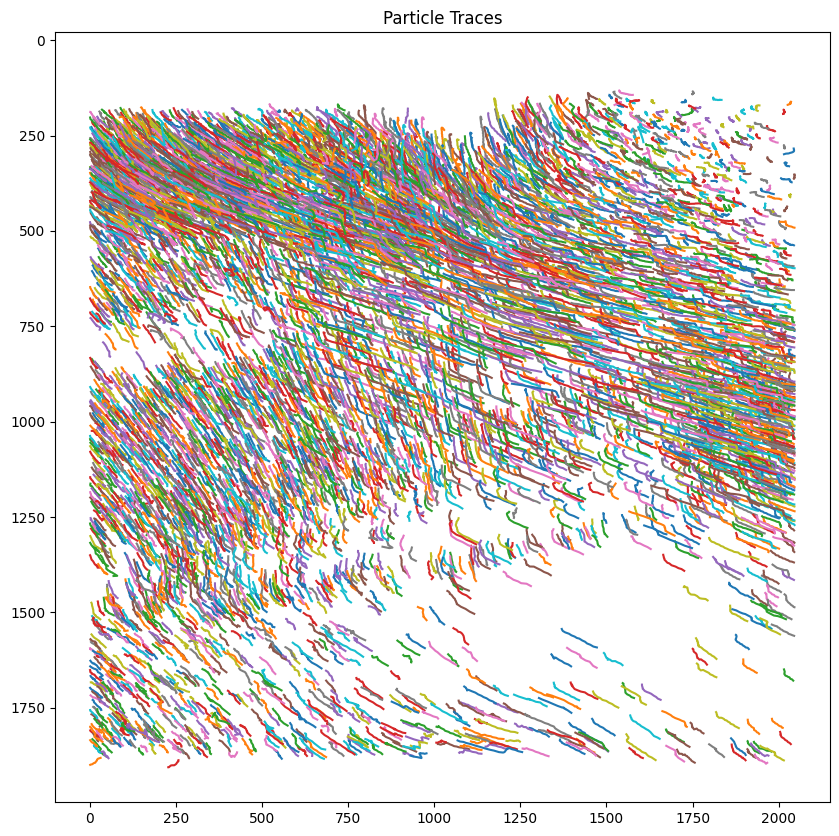

In [16]:
import multiprocessing as mp
import numpy as np

def process_image(filename1, filename2):
    coords1, coords2 = som.read_in_coordinates(filename1, filename2)
    coords1, coords2 = som.match_2048_images(coords1, coords2)
    return coords1, coords2

def main():
    starting_image = 450
    images_to_match = 50
    particle_folder = '2048_positions/'
    #particle_folder = '2048_positions_2/'
    min_length = 15
    position_files = [os.path.join(particle_folder, img) for img in os.listdir(particle_folder) if img.endswith(".npy")]
    position_files.sort()
    
    pool = mp.Pool(mp.cpu_count()-1)
    
    results = []
    for i in range(min(images_to_match,len(position_files)-1)):
        filename1 = position_files[i]
        filename2 = position_files[i+1]
        results.append(pool.apply_async(process_image, args=(filename1, filename2)))
    
    allmatches = np.array((),dtype=object)
    original_coords = np.array((),dtype=object)
    for i, result in enumerate(results):
        coords1, coords2 = result.get()
        if i==0:
            match = np.array((coords1,coords2),dtype=object)
        elif i>0:
            match = np.array([coords2,None],dtype=object)
            match = np.delete(match,1)
        orig_coords = np.array([coords1,None],dtype=object)
        orig_coords = np.delete(orig_coords,1)
        allmatches = np.append(allmatches,match)
        original_coords = np.append(original_coords,orig_coords)    
        print(f"finished image number {i+1}")
    
    pool.close()
    pool.join()

    print("now tracing")
    allmatches = som.tracing(allmatches, original_coords)
    dataframe = som.convert_to_dataframe(allmatches, starting_image)
    filtered_particles = som.dataframe_min_length_filter(dataframe, min_length)
    som.plot_traces(filtered_particles)

if __name__ == "__main__":
    main()

# Quiver plot for quick visualization

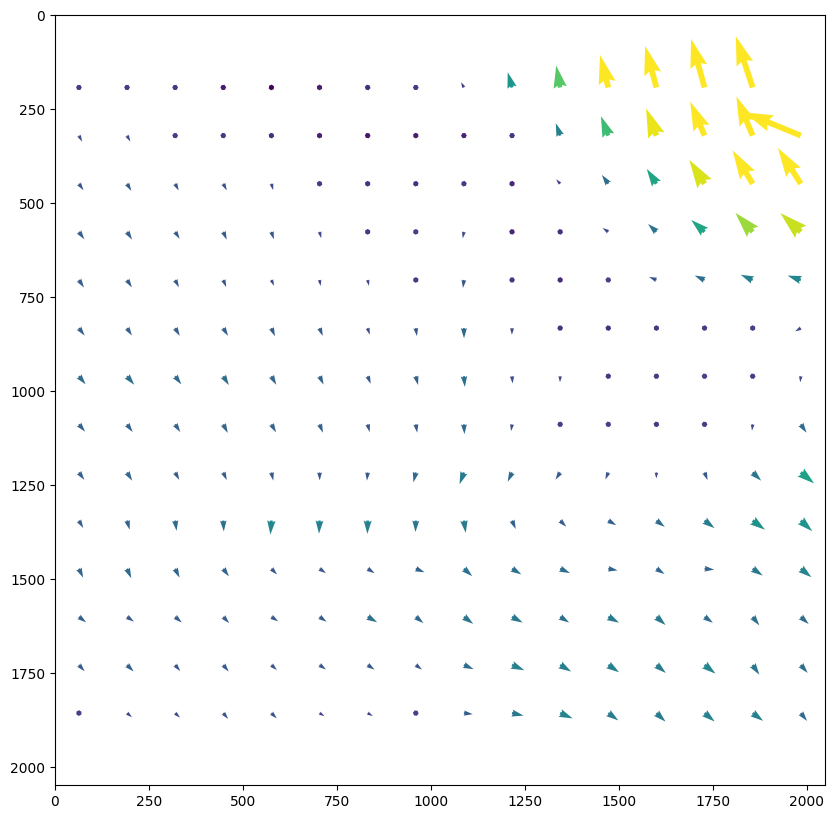

In [17]:
particle_folder = '2048_positions/'
#particle_folder = '2048_positions_2/'
position_files = [os.path.join(particle_folder, img) for img in os.listdir(particle_folder) if img.endswith(".npy")]
position_files.sort()
filename1 = position_files[0]
filename2 = position_files[1]
coords1, coords2 = som.read_in_coordinates(filename1, filename2)
coords1, coords2 = som.match_2048_images(coords1, coords2)
som.quiver_plot(coords1,coords2,16)